# Lesson 2: Transformer Decoder Architecture (nanoGPT)

In this lesson, we will deconstruct the Transformer Decoder architecture used in nanoGPT. We will focus on Multi-Head Attention, residual blocks, and the crucial role of Layer Normalization.

## 1. Multi-Head Attention Architecture

Multi-Head Attention allows the model to look at different parts of the sequence simultaneously. Each "head" focuses on a different relationship between tokens.

### Mermaid Diagram: Multi-Head Attention (nanoGPT style)

In **nanoGPT**, Multi-Head Attention is implemented as a collection of independent `Head` modules. Each head "sees" the same input but has its own learned weights.

```mermaid
graph TD
    Input("Input (B, T, C)") --> Head1["Head 1 (Q, K, V)"]
    Input --> Head2["Head 2 (Q, K, V)"]
    Input --> HeadN["Head N (Q, K, V)"]
    
    subgraph SingleHead ["Inside each Head module"]
        Q["Q = x @ W_q"]
        K["K = x @ W_k"]
        V["V = x @ W_v"]
        Attn["Attention = softmax(QK^T / sqrt) @ V"]
        Q --> Attn
        K --> Attn
        V --> Attn
    end
    
    Head1 --> Cat["torch.cat (Concatenation)"]
    Head2 --> Cat
    HeadN --> Cat
    
    Cat --> OutProj["Output Projection (proj)"]
    OutProj --> Result("Final Multi-Head Output")
```

## 2. Transformer Block (The Residual Unit)

A standard Transformer Block consists of two main sub-layers: **Self-Attention** and **Feed-Forward**. Crucially, it uses **Residual Connections** and **Layer Normalization** to enable training very deep networks.

### Mermaid Diagram: Transformer Block

```mermaid
graph TD
    In("Input (x)") --> LN1["LayerNorm 1 (Pre-norm)"]
    LN1 --> MHA["Multi-Head Attention"]
    In --> Res1("+")
    MHA --> Res1
    
    Res1 --> LN2["LayerNorm 2 (Pre-norm)"]
    LN2 --> FFN["Feed Forward Network (MLP)"]
    Res1 --> Res2("+")
    FFN --> Res2
    
    Res2 --> Out("Output")
```

## 3. Deep Dive: Why Two LayerNorms?

In nanoGPT, we use the **Pre-norm** formulation (applying LayerNorm *before* the sub-layer). This is the modern standard used in models like GPT-2, GPT-3, and Llama.

### Theory: Stability and Gradient Flow
1. **Stabilizing Activations**: NN layers naturally tend to increase the variance of activations as you go deeper. LayerNorm re-centers and re-scales these activations, preventing values from exploding.
2. **Gradient Flow**: By using residual connections `x = x + sublayer(norm(x))`, the "original" signal `x` has a direct path to the output. The sub-layers only calculate "incremental updates" to this signal.
3. **Two Norms for Two Tasks**:
   - **LN1**: Prepares the data for **Spatial Communication** (Attention). It ensures that tokens are comparing themselves on a normalized scale.
   - **LN2**: Prepares the data for **Individual Computation** (MLP). It ensures the MLP receives stable input for its nonlinear transformations.

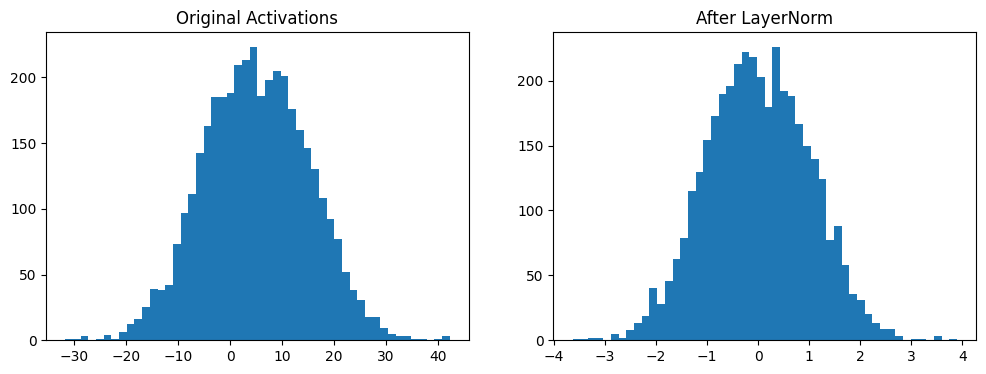

Original Mean: 5.03, Std: 10.06
Normalized Mean: 0.00, Std: 1.00


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Simple experiment to show LayerNorm effect
x = torch.randn(10, 384) * 10 + 5 # Mean 5, Std 10
ln = nn.LayerNorm(384)
y = ln(x)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(x.flatten().detach().numpy(), bins=50)
plt.title("Original Activations")

plt.subplot(1, 2, 2)
plt.hist(y.flatten().detach().numpy(), bins=50)
plt.title("After LayerNorm")
plt.show()

print(f"Original Mean: {x.mean():.2f}, Std: {x.std():.2f}")
print(f"Normalized Mean: {y.mean():.2f}, Std: {y.std():.2f}")

## 4. Final Output Stage

After all $L$ blocks, we have the final sequence of embeddings. But we need predicted characters.

### `ln_f`: Final LayerNorm
Because of the residual stream, the final embedding vector can have very high values. `ln_f` provides one last normalization before the final linear projection. Without this, the training can be unstable as the model matures.

### `lm_head`: Linear Header
The Language Modeling head is a simple `nn.Linear(n_embd, vocab_size)` layer. It transforms the final normalized embedding (e.g., dimension 384) into "Logits" for each character in the vocabulary (e.g., 65 dimensions).

1. **Input**: Normalized embedding $(B, T, C)$
2. **Operation**: $Logits = X \cdot W + b$
3. **Output**: $(B, T, V)$ where $V$ is vocabulary size.

These logits are then fed into Softmax during generation or Cross-Entropy during training.

## 5. Summary of the Data Flow

1. **Input**: Sequence of tokens.
2. **Embedding**: Identity converted to vectors.
3. **Blocks**: Refine these vectors through communication (Attention) and calculation (MLP).
4. **Exit**: `ln_f` stabilizes everything, and `lm_head` gives us the final scores (Logits).

| Layer | Purpose | Logical Analogy |
|---|---|---|
| `MultiHeadAttention` | Communication | Tokens "talking" to each other to share context. |
| `FeedForward` | Individual Thought | Each token processing the shared context independently. |
| `LayerNorm` | Distribution Control | Keeps the values from becoming too large or small during training. |
| `lm_head` | Prediction | Translates the final high-dimensional vector into an alphabetical character. |